# Offset Ground-truthing

## In geo environment

In [46]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime

In [70]:
path = 'peg_data/Rangitikei Landslide_peg displacement_sample.xlsx'
names = ['P22','P21','P14','P11','P5']
df = pd.DataFrame()

for n in names:
    temp = pd.read_excel(path, sheet_name=n).sort_values('Survey date')
    temp['Cumulative E disp'] = temp['E disp'].cumsum()
    temp['Cumulative N disp'] = temp['N disp'].cumsum()
    df = df.append(temp)

In [71]:
pegs = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df['Easting'], y=df['Northing'], z=df['Elevation (NZVD2016)'], crs='EPSG:2193'))

In [72]:
pegs = pegs.to_crs(epsg=32760)

pegs['Easting'] = pegs.geometry.x
pegs['Northing'] = pegs.geometry.y
pegs['Elevation'] = pegs.geometry.z

In [73]:
pegs.to_csv('peg_data/pegs_32760.csv')
print(pegs.columns)

Index(['Survey date', 'Name', 'Survey number', 'Easting', 'Northing',
       'Elevation (NZVD2016)', 'E disp', 'N disp', 'V disp', 'Net H disp',
       'net H&V disp', 'net disp/yr', 'cum net disp', 'Cumulative E disp',
       'Cumulative N disp', 'geometry', 'Elevation'],
      dtype='object')


## In MintPy environment

In [1]:
pwd

'/home/fw/data/pixeloffset_mintpy'

In [3]:
# from mintpy.utils import readfile
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mintpy.tsview import timeseriesViewer
from mintpy.objects import timeseries
from datetime import datetime
import pandas as pd
import numpy as np

In [4]:
pegs = pd.read_csv('peg_data/pegs_32760.csv',index_col=0)
locations = pegs[['Name', 'Easting', 'Northing']].groupby('Name').mean().reset_index()
locations['row'] = None
locations['column'] = None

print(pegs.columns)

Index(['Survey date', 'Name', 'Survey number', 'Easting', 'Northing',
       'Elevation (NZVD2016)', 'E disp', 'N disp', 'V disp', 'Net H disp',
       'net H&V disp', 'net disp/yr', 'cum net disp', 'Cumulative E disp',
       'Cumulative N disp', 'geometry', 'Elevation'],
      dtype='object')


In [7]:
tsobj_ns = timeseries('../upper_poroa/timeseriesAz.h5')
tsobj_ew = timeseries('../upper_poroa/timeseriesRg.h5')

atr = tsobj_ns.get_metadata()
dates = tsobj_ns.get_date_list()
len(dates)

26

In [8]:
x_first, y_first, x_step, y_step = [float(x) for x in [atr['X_FIRST'], atr['Y_FIRST'], atr['X_STEP'], atr['Y_STEP']]]

for i, row in locations.iterrows():
    dX = row['Easting'] - x_first
    x_loc = int(np.floor(dX / x_step))
    dY = row['Northing'] - y_first
    y_loc = int(np.floor(dY / y_step))
    locations.iloc[i,3] = y_loc
    locations.iloc[i,4] = x_loc

locations.to_csv('peg_data/locations.csv',index=False)
print(locations)

     Name        Easting      Northing  row column
0  Peg 05  401864.928303  5.599635e+06  118     79
1  Peg 11  401697.900873  5.599281e+06  127     74
2  Peg 14  401694.803872  5.599143e+06  130     74
3  Peg 21  401809.341253  5.598824e+06  138     77
4  Peg 22  401768.407891  5.598724e+06  141     76


In [10]:
cosicorr = pd.DataFrame()

template = pd.DataFrame({'Date':dates,'Cumulative E disp':None,'Cumulative N disp':None})
template['Date'] = pd.to_datetime(template['Date'], format='%Y%m%d')

for i, row in locations.iterrows():
    tmp = template.copy()
    box = (row['column'],row['row'],row['column']+1,row['row']+1)
    tmp['Cumulative N disp'] = tsobj_ns.read(box=box)
    tmp['Cumulative E disp'] = tsobj_ew.read(box=box)
    tmp['Name'] = row['Name']
    cosicorr = cosicorr.append(tmp)

cosicorr = cosicorr.reset_index(drop=True)
cosicorr['Source'] = 'cosicorr'
cosicorr

reading timeseries data from file: ../upper_poroa/timeseriesAz.h5 ...
reading timeseries data from file: ../upper_poroa/timeseriesRg.h5 ...
reading timeseries data from file: ../upper_poroa/timeseriesAz.h5 ...
reading timeseries data from file: ../upper_poroa/timeseriesRg.h5 ...
reading timeseries data from file: ../upper_poroa/timeseriesAz.h5 ...
reading timeseries data from file: ../upper_poroa/timeseriesRg.h5 ...
reading timeseries data from file: ../upper_poroa/timeseriesAz.h5 ...
reading timeseries data from file: ../upper_poroa/timeseriesRg.h5 ...
reading timeseries data from file: ../upper_poroa/timeseriesAz.h5 ...
reading timeseries data from file: ../upper_poroa/timeseriesRg.h5 ...


,Date,Cumulative E disp,Cumulative N disp,Name,Source
0,2016-02-06,0.000000,0.000000,Peg 05,cosicorr
1,2016-11-22,0.704643,-2.425628,Peg 05,cosicorr
2,2017-04-21,3.314628,1.956429,Peg 05,cosicorr
3,2017-05-01,0.951265,0.201615,Peg 05,cosicorr
4,2017-05-21,0.989002,0.075689,Peg 05,cosicorr
...,...,...,...,...,...
125,2020-08-03,-2.823253,-10.163726,Peg 22,cosicorr
126,2020-12-16,4.849927,0.695050,Peg 22,cosicorr
127,2021-01-25,5.654144,-10.279912,Peg 22,cosicorr
128,2021-02-19,5.037361,-3.609229,Peg 22,cosicorr


In [11]:
pegs_merge = pegs[['Survey date', 'Cumulative E disp', 'Cumulative N disp', 'Name']].copy()
pegs_merge = pegs_merge.rename(columns={'Survey date':'Date'})
pegs_merge['Source'] = 'gps'

In [15]:
comparison = cosicorr.append(pegs_merge)
comparison.to_csv('peg_data/comparsion_median.csv')

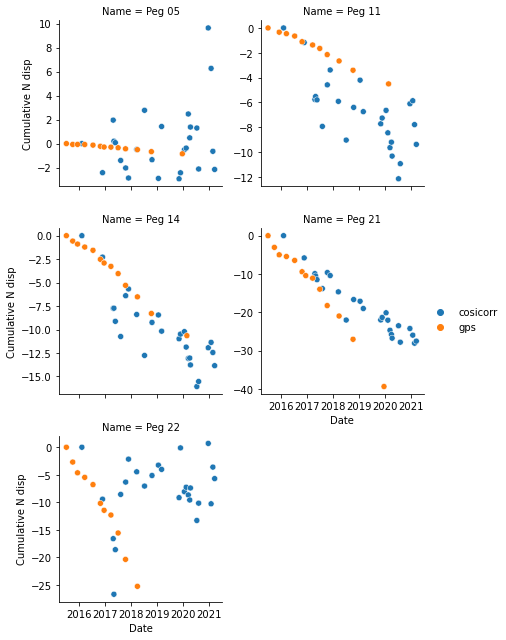

In [16]:
comparison = pd.read_csv('peg_data/comparsion_median.csv',parse_dates=['Date'])
names = ['P5','P11','P14','P21','P22',]

g = sns.FacetGrid(comparison, col='Name',sharey=False, col_wrap=2)
g.map(sns.scatterplot, 'Date', 'Cumulative N disp','Source')
g.add_legend()

# plt.savefig('n_displacement_comparison.png')

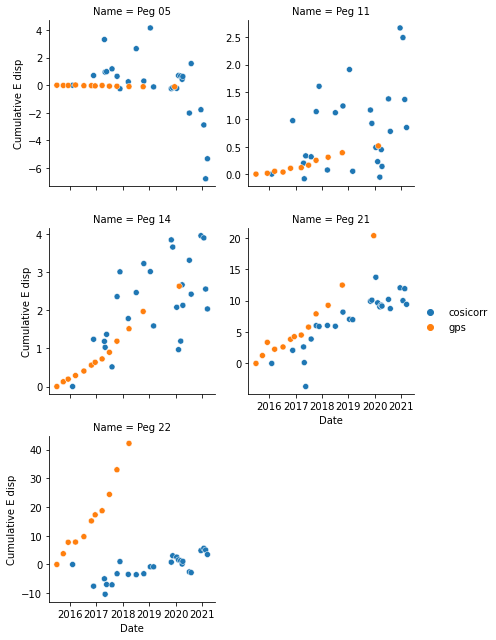

In [17]:
g = sns.FacetGrid(comparison, col='Name',sharey=False, col_wrap=2)
g.map(sns.scatterplot, 'Date', 'Cumulative E disp','Source')
g.add_legend()

In [37]:
pwd

'/home/fw/data/pixeloffset_mintpy'

## TSview

In [18]:
# visualization functions
def tsview(fname, yx=None):
    """Plot input file using tsview.py"""
    cmd = 'tsview.py {} --ms 4 --noverbose'.format(fname)
    if yx is not None:
        cmd += ' --yx {} {}'.format(yx[0], yx[1])
    print(cmd)
    obj = timeseriesViewer(cmd)
    obj.configure()
    obj.figsize_img = [5, 4]
    obj.figsize_pts = [5, 2]
    obj.plot()
    return obj

tsview.py ../upper_poroa/timeseriesAz.h5 --ms 4 --noverbose
tsview.py ../upper_poroa/timeseriesAz.h5 --ms 4 --noverbose
No lookup table info range/lat found in files.
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}


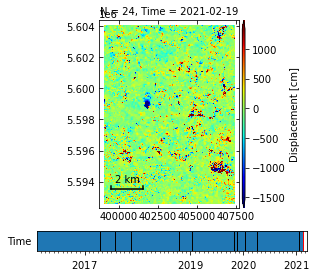

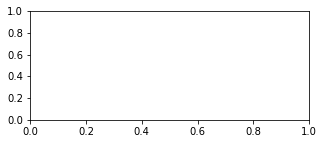

In [21]:
# timeseriesAz
obj = tsview('../upper_poroa/timeseriesAz.h5')